# Introduction 

- Steps I did:
    - [x] Copied data from Matlab Brainstorm folder to separate one
    - [x] Loaded them into `xarray` `Datarray`s containers


In [1]:
import shutil
import re
import numpy as np
import xarray as xr
import scipy.io as sio
from glob import glob
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import ggseg

from fooof import  FOOOFGroup

from poirot.spectrum import  specparam_attributes, my_compute_spectrum
from neurodsp.spectral import compute_spectrum

import seaborn as sns
sns.set_theme(style="whitegrid")

def copy_without_patterns(input_path, destination_path, list_of_patterns):
    try:
        shutil.copytree(input_path, destination_path, ignore=shutil.ignore_patterns(*list_of_patterns))
    except FileExistsError  as err:
        print(err)

def create_subject_names():
    PATTERN_A = "Subject{}_A"
    PATTERN_B = "Subject{}_B"
    SUBS = []
    for i in range(1, 16):
        padded_num = str(i).zfill(2)
        SUBS.extend(
            (PATTERN_A.format(padded_num), PATTERN_B.format(padded_num))
        )
    return SUBS

def my_compute_spectrum(data, fs, nperseg):
    """
    Computes the power spectrum of a signal.

    Args:
        data (_type_): _description_
        fs (_type_): _description_
        nperseg (_type_): _description_

    Returns:
        _type_: _description_
    """
    sig , spectrum = compute_spectrum(data, fs=fs,nperseg=nperseg)
    return  spectrum

def load_single_subject(DATA_FOLDER,sub):
    list_trials = []
    trials = [Path(p) for p in glob(f"{DATA_FOLDER}/brainstorm/{sub}_*.mat")]
    for trial in trials:
            trial_number = re.findall(r"\d+", str(trial))[-1]
            iter_number = re.findall(r"\d{2}_resample", str(trial))[-1]
            # display(trial_number)
            mstruct = sio.loadmat(trial)
            values = mstruct["Value"]
            # time = mstruct["Time"][0] - mstruct["Time"][0][0]
            #time = np.linspace(0, 5, 3000)
            time = np.linspace(-2, 2, 2401)
            label_struct = mstruct["Atlas"][
                0, 0]["Scouts"]["Label"].ravel().tolist()
            labels = np.array([item.item() for item in label_struct])
            region_struct = mstruct["Atlas"][
                0, 0]["Scouts"]["Region"].ravel().tolist()
            regions = np.array([item.item() for item in region_struct])
            single_trial = (
                xr.DataArray(
                    values.T,
                    dims= ["time", "labels"],
                    coords={
                        "labels": labels,
                        "time": time,
                        "sub": sub,
                        "iter_number": iter_number,
                        "trial": int(trial_number)
                    })
                .expand_dims('trial')
                .expand_dims("iter_number")
                .expand_dims("sub")
                .assign_coords(regions = ("labels", regions)))
            list_trials.append(single_trial)      
    ds = xr.combine_by_coords(list_trials)
    ds.to_netcdf(f"{DATA_FOLDER}/interim/timeseries/{sub}_MEG_ASSR_times.nc")
    return ds


In [2]:
input_path = "/Volumes/ExtremePro/Brainstorm/tDCS_MEG_Marinazzo/data/" # source path 
destination_path = "/Volumes/ExtremePro/Brainstorm/tDCS_MEG_Copy/data/" # destination path
patterns = ["@raw*"] #pattern to exclude

copy_without_patterns(input_path,destination_path, patterns)
# After this the part of analysis in Brainstorm can be done; after runing the scripr in Matlab we return to Python



[Errno 17] File exists: '/Volumes/ExtremePro/Brainstorm/tDCS_MEG_Copy/data/'


# Iterate over all subject, load them into xarray array and then save them into netcdf file

In [6]:
SUBS = create_subject_names()
print(SUBS)
DATA_FOLDER = "/Volumes/ExtremePro/Analyses/tDCS_MEG"
with tqdm(total=len(SUBS)) as pbar:
    for sub in SUBS:
        ds = load_single_subject(DATA_FOLDER,sub)
        pbar.update(1)



['Subject01_A', 'Subject01_B', 'Subject02_A', 'Subject02_B', 'Subject03_A', 'Subject03_B', 'Subject04_A', 'Subject04_B', 'Subject05_A', 'Subject05_B', 'Subject06_A', 'Subject06_B', 'Subject07_A', 'Subject07_B', 'Subject08_A', 'Subject08_B', 'Subject09_A', 'Subject09_B', 'Subject10_A', 'Subject10_B', 'Subject11_A', 'Subject11_B', 'Subject12_A', 'Subject12_B', 'Subject13_A', 'Subject13_B', 'Subject14_A', 'Subject14_B', 'Subject15_A', 'Subject15_B']


100%|██████████| 30/30 [03:30<00:00,  7.02s/it]


In [5]:
x = {'01_resample':'pre', '03_resample':'pre', '02_resample':'post','04_resample':'post'}
ds.assign_coords({"cond": ("iter_number", x)})


ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): ('iter_number', {'01_resample': 'pre', '03_resample': 'pre', '02_resample': 'post', '04_resample': 'post'}) to Variable.

In [18]:
        
fs = 600

fg = FOOOFGroup(
    peak_width_limits=[2, 8],
    min_peak_height=0.1,
    max_n_peaks=6,
)

freq_range = [2, 45]
stacked_cols = ['labels','sub', 'iter_number']


from poirot.translate import define_region_dict, prepare_grouping
def add_coordinate(da, coordinate, partition_dict, new_coordinate):
    temp = prepare_grouping(da, coordinate, partition_dict)
    return da.assign_coords({new_coordinate: (coordinate, temp)})

def apply_spectrum(da, fs):
    return xr.apply_ufunc(
        my_compute_spectrum, 
        da, 
        vectorize=True, 
        input_core_dims=[['time']], 
        output_core_dims=[['freqs']], 
        kwargs =  {"fs" :fs, "nperseg":1*fs})

SUBS = ["Subject01_A", "Subject01_B"]
SUBS = create_subject_names()
list_spectrum = []

for sub in tqdm(SUBS):
    dt = (
        xr.load_dataarray(f"{DATA_FOLDER}/interim/timeseries/{sub}_MEG_ASSR_times.nc")
        .sel(time= (slice(0,1)))
        .pipe(apply_spectrum, fs = fs)
        .assign_coords(freqs = lambda x: np.linspace(0,fs/2, len(x.freqs)))
        .mean("trial")
        #.mean("iter_number")
        .pipe(
            specparam_attributes,
            stacked_cols=stacked_cols,
            fg=fg,
            freq_range=freq_range,
        )
        # .drop(['CF', 'PW', "BW"], axis=1)
        # .drop_duplicates()
        # .assign(labels_atlas=lambda x: x.labels.str.replace('L','left').str.replace('R','right').str.replace(' ','_'))
        # .groupby(['labels_atlas', 'sub'])
        # .mean("exponent")
        # .reset_index()
        # .groupby(['labels_atlas'])
        # .mean("exponent")
        # .reset_index()
        # .loc[:, ['labels_atlas', 'exponent']]
    )
    list_spectrum.append(dt)
    # data_dt = dict(zip(dt.labels_atlas, dt.exponent))
    # # display(data_dx)
    # ggseg.plot_dk(data_dt, background='w', edgecolor='k', cmap='Blues')



100%|██████████| 30/30 [04:54<00:00,  9.82s/it]


In [20]:
psds = pd.concat(list_spectrum)
psds

,labels,sub,iter_number,regions,CF,PW,BW,offset,exponent,error,r_squared
0,bankssts L,Subject01_A,01_resample,LT,11.073719,0.226285,5.780088,-23.286866,0.709908,0.038354,0.969493
1,bankssts L,Subject01_A,01_resample,LT,40.126222,0.172266,2.000000,-23.286866,0.709908,0.038354,0.969493
2,bankssts L,Subject01_A,02_resample,LT,10.658101,0.230108,5.641269,-23.364796,0.654651,0.028489,0.978620
3,bankssts L,Subject01_A,02_resample,LT,40.258344,0.200945,2.000000,-23.364796,0.654651,0.028489,0.978620
4,bankssts R,Subject01_A,01_resample,RT,9.596421,0.313370,4.801316,-22.672097,0.873474,0.020987,0.993197
...,...,...,...,...,...,...,...,...,...,...,...
357,transversetemporal R,Subject15_B,01_resample,RT,20.014518,0.498411,8.000000,-21.419870,1.228655,0.036591,0.992407
358,transversetemporal R,Subject15_B,01_resample,RT,39.905191,0.539615,2.000000,-21.419870,1.228655,0.036591,0.992407
359,transversetemporal R,Subject15_B,02_resample,RT,10.410674,0.669714,5.864144,-21.465642,1.150667,0.053449,0.985083
360,transversetemporal R,Subject15_B,02_resample,RT,18.664333,0.590451,8.000000,-21.465642,1.150667,0.053449,0.985083


In [23]:
psds.dtypes
stringcols = psds.select_dtypes(include='object').columns
stringcols 

Index(['labels', 'sub', 'iter_number', 'regions'], dtype='object')

Running FOOOFGroup: 100%|██████████| 68/68 [00:02<00:00, 26.64it/s]


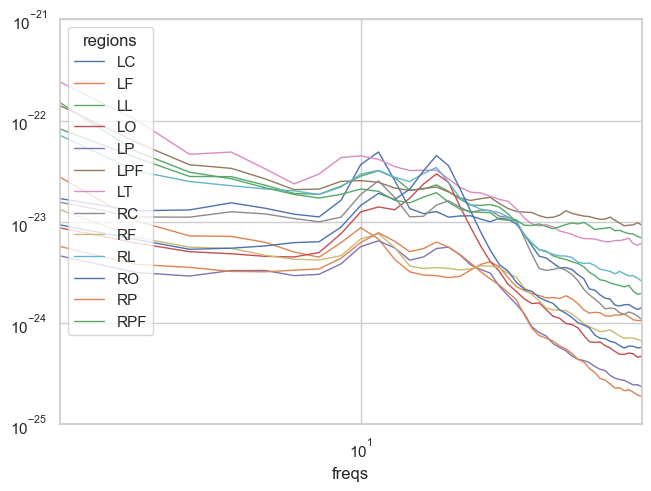

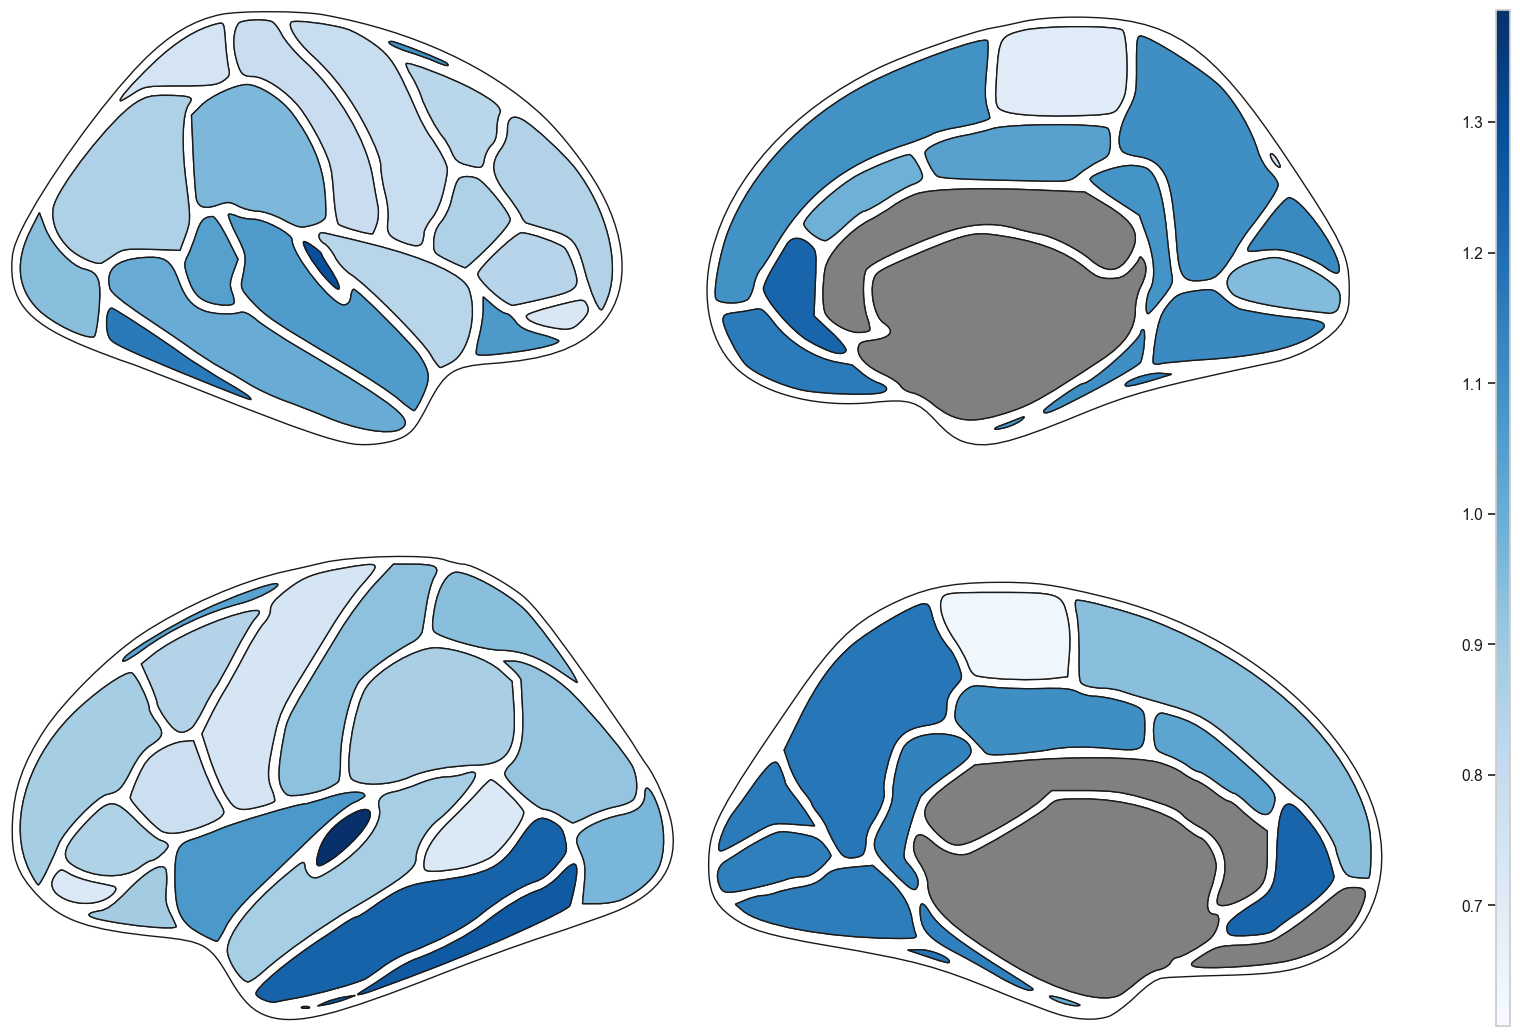

In [7]:
        
fs = 600

fg = FOOOFGroup(
    peak_width_limits=[2, 8],
    min_peak_height=0.1,
    max_n_peaks=6,
)

freq_range = [2, 45]
stacked_cols = ['labels','sub']


from poirot.translate import define_region_dict, prepare_grouping
def add_coordinate(da, coordinate, partition_dict, new_coordinate):
    temp = prepare_grouping(da, coordinate, partition_dict)
    return da.assign_coords({new_coordinate: (coordinate, temp)})

SUBS = ["Subject01_A", "Subject01_B"]

with tqdm(total=len(SUBS)) as pbar:
    for sub in SUBS:
        da = xr.open_dataarray(f"{DATA_FOLDER}/interim/timeseries/{sub}_MEG_ASSR_times.nc")
        da.close()

        pbar.update(1)

dt = da.sel(time= (slice(0,1)))

def apply_ufunc(da, func, **kwargs):
    return xr.apply_ufunc(func, da, vectorize=True, input_core_dims=[['time']], output_core_dims=[['freqs']], kwargs = kwargs)

da

temp_df = (
    xr.apply_ufunc(
        my_compute_spectrum, dt, 
        vectorize=True,
        input_core_dims=[['time']],
        output_core_dims=[['freqs']],
        kwargs = {"fs" :fs, "nperseg":1*fs})
    .assign_coords(freqs = lambda x: np.linspace(0,fs/2, len(x.freqs)))
    .mean("trial")
    .mean("iter_number")
    .pipe(
        specparam_attributes,
        stacked_cols=stacked_cols,
        fg=fg,
        freq_range=freq_range,
    )
)

fig, ax = plt.subplots(layout='constrained')

dt = ds.sel(time= (slice(-1,0)))

y = (
     xr.apply_ufunc(
        my_compute_spectrum, dt, 
        vectorize=True,
        input_core_dims=[['time']],
        output_core_dims=[['freqs']],
        kwargs = {"fs" :fs, "nperseg":1*fs})
    .assign_coords(freqs = lambda x: np.linspace(0,fs/2, len(x.freqs)))
    .mean("trial")
    .mean("iter_number")
    .mean("sub")
    .groupby("regions")
    .mean("labels")
)
# display(y)
(y
 .isel(regions=slice(0, 13))
 .plot.line(
    x="freqs",  xlim=[2, 45], ylim = [10e-26, 10e-22 ], yscale='log', xscale='log', linewidth=1.0)
 ) # type: ignore
# fig.legend(loc='outside right upper')
plt.show()

# Learn more about pandas Grouper: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html
dx = (
    temp_df
    .drop(['CF', 'PW', "BW"], axis=1)
    .drop_duplicates()
    .assign(labels_atlas=lambda x: x.labels.str.replace('L','left').str.replace('R','right').str.replace(' ','_'))
    .groupby(['labels_atlas', 'sub'])
    .mean("exponent")
    .reset_index()
    .groupby(['labels_atlas'])
    .mean("exponent")
    .reset_index()
    .loc[:, ['labels_atlas', 'exponent']]
)
# display(dx)
data_dx = dict(zip(dx.labels_atlas, dx.exponent))
# display(data_dx)
ggseg.plot_dk(data_dx, background='w', edgecolor='k', cmap='Blues')

 The data were preprocessed, projected into Destrieux brain atlas and the ITPC was computed for 1s second pre-stimulus period and stimulation period, for each of the regions using the wavelet approach described in Pellegrino et al. (2019). • The slope and exponent of the spectrum were also computed for each region